In [3]:
import os 
os.environ['XDG_SESSION_TYPE'] = 'x11'
import open3d as o3d

In [2]:
from photogrammetry_ai import (
    PhotogrammetryPipeline,
    LightGlueMatcher,
    VGGTReconstructor,
    ICPAligner,
)
import os

image_dir = "/home/jourdelune/Images/colmap/input"

images = os.listdir(image_dir)
images = [
    os.path.join(image_dir, img)
    for img in images
    if img.lower().endswith((".jpg", ".jpeg", ".png"))
]


pipeline = PhotogrammetryPipeline(
    matcher=LightGlueMatcher(),  # used to create related batches of images
    reconstructor=VGGTReconstructor(),  # used to reconstruct the 3D points from the images
    aligner=ICPAligner(),  # used to merges the 3D points from the batches
    max_batch_size=3,
    min_match_count=200,
    batch_args={
        "overlopping_images": 1,  # number of images to overlap in each batch
    }
)


/home/jourdelune/Bureau/dev/photogrammetry_ai/.venv/lib/python3.12/site-packages/lightglue/lightglue.py:24: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)


/home/jourdelune/Bureau/dev/photogrammetry_ai/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128279 (\N{LINK SYMBOL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


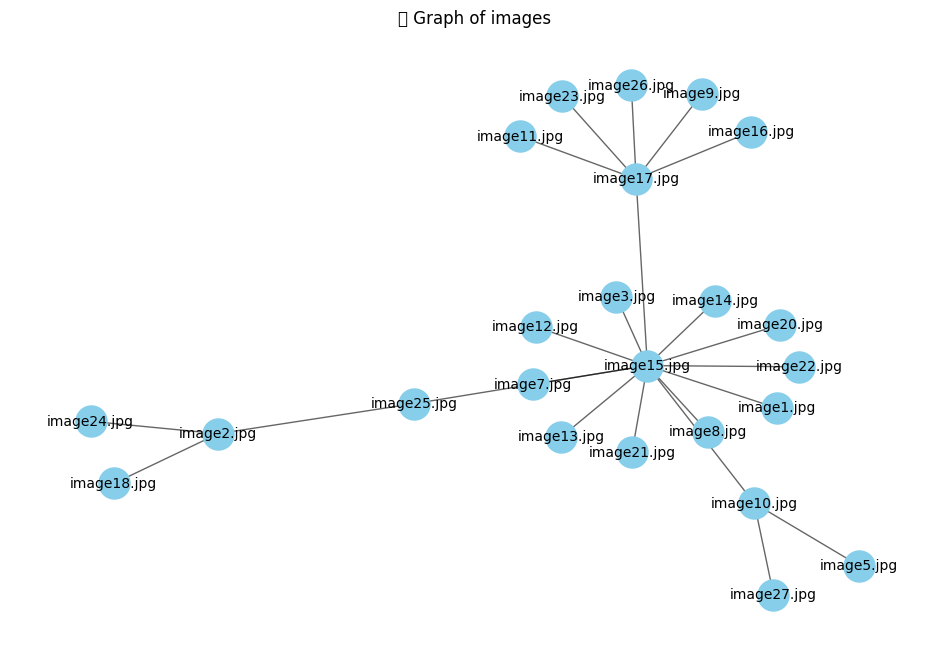

Found 12 batches with 2 missing images.


In [3]:
batches, missing_images = pipeline.build_batches(images, display_graph=True)
print(f"Found {len(batches)} batches with {len(missing_images)} missing images.")

In [4]:
for batch in batches:
    print(batch)

['/home/jourdelune/Images/colmap/input/image15.jpg', '/home/jourdelune/Images/colmap/input/image17.jpg', '/home/jourdelune/Images/colmap/input/image11.jpg']
['/home/jourdelune/Images/colmap/input/image11.jpg', '/home/jourdelune/Images/colmap/input/image23.jpg', '/home/jourdelune/Images/colmap/input/image9.jpg']
['/home/jourdelune/Images/colmap/input/image9.jpg', '/home/jourdelune/Images/colmap/input/image26.jpg', '/home/jourdelune/Images/colmap/input/image16.jpg']
['/home/jourdelune/Images/colmap/input/image16.jpg', '/home/jourdelune/Images/colmap/input/image13.jpg', '/home/jourdelune/Images/colmap/input/image12.jpg']
['/home/jourdelune/Images/colmap/input/image12.jpg', '/home/jourdelune/Images/colmap/input/image22.jpg', '/home/jourdelune/Images/colmap/input/image10.jpg']
['/home/jourdelune/Images/colmap/input/image10.jpg', '/home/jourdelune/Images/colmap/input/image5.jpg', '/home/jourdelune/Images/colmap/input/image27.jpg']
['/home/jourdelune/Images/colmap/input/image27.jpg', '/home/j

In [ ]:
import os
import numpy as np
import torch
import trimesh
from torch.nn import functional as F
from vggt.models.vggt import VGGT
from vggt.utils.geometry import unproject_depth_map_to_point_map
from vggt.utils.helper import create_pixel_coordinate_grid, randomly_limit_trues
from vggt.utils.load_fn import load_and_preprocess_images_square
from vggt.utils.pose_enc import pose_encoding_to_extri_intri

device = "cuda" if torch.cuda.is_available() else "cpu"
dtype = torch.bfloat16 if torch.cuda.get_device_capability()[0] >= 8 else torch.float16

model = VGGT.from_pretrained("facebook/VGGT-1B").to(device)


vggt_fixed_resolution = 518
img_load_resolution = 1024

print(f"Batch size: {len(batches)}, total images: {len(images)}")
batched_extrinsic, batched_intrinsic = [], []
batched_points_3d, batched_points_rgb, batched_points_xyf = [], [], []


for batch in batches:
    # Load all images
    images_all, original_coords_all = load_and_preprocess_images_square(
        batch, img_load_resolution
    )

    images_batch = images_all.to(device)
    original_coords = original_coords_all.to(device)

    # Resize and run VGGT
    images_resized = F.interpolate(
        images_batch,
        size=(vggt_fixed_resolution, vggt_fixed_resolution),
        mode="bilinear",
        align_corners=False,
    )

    with torch.no_grad():
        with torch.cuda.amp.autocast(dtype=dtype):
            images_input = images_resized[None]
            aggregated_tokens_list, ps_idx = model.aggregator(images_input)
            pose_enc = model.camera_head(aggregated_tokens_list)[-1]
            extrinsic, intrinsic = pose_encoding_to_extri_intri(
                pose_enc, images_input.shape[-2:]
            )
            depth_map, depth_conf = model.depth_head(
                aggregated_tokens_list, images_input, ps_idx
            )

    extrinsic = extrinsic.squeeze(0).cpu().numpy()
    intrinsic = intrinsic.squeeze(0).cpu().numpy()
    depth_map = depth_map.squeeze(0).cpu().numpy()
    depth_conf = depth_conf.squeeze(0).cpu().numpy()

    points_3d = unproject_depth_map_to_point_map(depth_map, extrinsic, intrinsic)
    
    

    image_size = np.array([vggt_fixed_resolution, vggt_fixed_resolution])
    num_frames, height, width, _ = points_3d.shape

    points_rgb = (images_resized.cpu().numpy() * 255).astype(np.uint8)
    points_rgb = points_rgb.transpose(0, 2, 3, 1)
    points_xyf = create_pixel_coordinate_grid(num_frames, height, width)

    conf_thres_value = 5.0
    max_points_for_colmap = 100000
    conf_mask = depth_conf >= conf_thres_value
    conf_mask = randomly_limit_trues(conf_mask, max_points_for_colmap)

    batched_extrinsic.append(extrinsic)
    batched_intrinsic.append(intrinsic)
    batched_points_3d.append(points_3d[conf_mask])
    batched_points_rgb.append(points_rgb[conf_mask])
    batched_points_xyf.append(points_xyf[conf_mask])

Batch size: 12, total images: 26


/tmp/ipykernel_29125/2344359914.py:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(dtype=dtype):


IndexError: index 3 is out of bounds for axis 1 with size 3

In [ ]:
import copy
from typing import Union

import numpy as np

def merge_and_draw(source: o3d.geometry.PointCloud, target: o3d.geometry.PointCloud, transformation: np.ndarray = np.identity(4)) -> o3d.geometry.PointCloud:
    source_temp = copy.deepcopy(source)
    target_temp = copy.deepcopy(target)
    source_temp.transform(transformation)
    merged = source_temp + target_temp
    return merged


In [ ]:
# generate source from the first batch
source = o3d.geometry.PointCloud()
source.points = o3d.utility.Vector3dVector(batched_points_3d[0])
source.colors = o3d.utility.Vector3dVector(batched_points_rgb[0] / 255.0)
source.estimate_normals()

In [ ]:
# generate target from the second batch
target = o3d.geometry.PointCloud()
target.points = o3d.utility.Vector3dVector(batched_points_3d[1])
target.colors = o3d.utility.Vector3dVector(batched_points_rgb[1] / 255.0)
target.estimate_normals()

In [ ]:
import copy

source_vis = copy.deepcopy(source)
target_vis = copy.deepcopy(target)

# Génère une transformation de translation (décalage)
translation = np.identity(4)
translation_bis = translation.copy()
translation_bis[:3, 3] = [2, 0.2, -0.3]  # exemple de décalage (x, y, z)

target_vis.transform(translation_bis)

o3d.visualization.draw_geometries([source_vis, target_vis])

In [ ]:
def preprocess_point_cloud(pcd, voxel_size):
    print(":: Downsample with a voxel size %.3f." % voxel_size)
    pcd_down = pcd.voxel_down_sample(voxel_size)

    radius_normal = voxel_size * 2
    print(":: Estimate normal with search radius %.3f." % radius_normal)
    pcd_down.estimate_normals(
        o3d.geometry.KDTreeSearchParamHybrid(radius=radius_normal, max_nn=30))

    radius_feature = voxel_size * 5
    print(":: Compute FPFH feature with search radius %.3f." % radius_feature)
    pcd_fpfh = o3d.pipelines.registration.compute_fpfh_feature(
        pcd_down,
        o3d.geometry.KDTreeSearchParamHybrid(radius=radius_feature, max_nn=100))
    return pcd_down, pcd_fpfh


voxel_size = 0.05 
demo_icp_pcds = o3d.data.DemoICPPointClouds()

trans_init = np.asarray([[0.0, 0.0, 1.0, 0.0], [1.0, 0.0, 0.0, 0.0],
                            [0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1.0]])
source.transform(trans_init)

source_down, source_fpfh = preprocess_point_cloud(source, voxel_size)
target_down, target_fpfh = preprocess_point_cloud(target, voxel_size)



:: Downsample with a voxel size 0.050.
:: Estimate normal with search radius 0.100.
:: Compute FPFH feature with search radius 0.250.
:: Downsample with a voxel size 0.050.
:: Estimate normal with search radius 0.100.
:: Compute FPFH feature with search radius 0.250.


In [ ]:
def execute_global_registration(source_down, target_down, source_fpfh,
                                target_fpfh, voxel_size):
    distance_threshold = voxel_size * 1.5
    print(":: RANSAC registration on downsampled point clouds.")
    print("   Since the downsampling voxel size is %.3f," % voxel_size)
    print("   we use a liberal distance threshold %.3f." % distance_threshold)
    result = o3d.pipelines.registration.registration_ransac_based_on_feature_matching(
        source_down, target_down, source_fpfh, target_fpfh, True,
        distance_threshold,
        o3d.pipelines.registration.TransformationEstimationPointToPoint(False),
        3, [
            o3d.pipelines.registration.CorrespondenceCheckerBasedOnEdgeLength(
                0.9),
            o3d.pipelines.registration.CorrespondenceCheckerBasedOnDistance(
                distance_threshold)
        ], o3d.pipelines.registration.RANSACConvergenceCriteria(100000, 0.999))
    return result


In [ ]:
result_ransac = execute_global_registration(source_down, target_down,
                                            source_fpfh, target_fpfh,
                                            voxel_size)
print(result_ransac)

o3d.visualization.draw_geometries([merge_and_draw(source_down, target_down, result_ransac.transformation)])

:: RANSAC registration on downsampled point clouds.
   Since the downsampling voxel size is 0.050,
   we use a liberal distance threshold 0.075.
RegistrationResult with fitness=6.409018e-01, inlier_rmse=3.861397e-02, and correspondence_set size of 2388
Access transformation to get result.


In [ ]:
def refine_registration(source, target, source_fpfh, target_fpfh, voxel_size):
    distance_threshold = voxel_size * 0.4
    print(":: Point-to-plane ICP registration is applied on original point")
    print("   clouds to refine the alignment. This time we use a strict")
    print("   distance threshold %.3f." % distance_threshold)
    result = o3d.pipelines.registration.registration_icp(
        source, target, distance_threshold, result_ransac.transformation,
        o3d.pipelines.registration.TransformationEstimationPointToPlane())
    return result


In [ ]:
result_icp = refine_registration(source, target, source_fpfh, target_fpfh,
                                 voxel_size)
print(result_icp)
o3d.visualization.draw_geometries([merge_and_draw(source, target, result_icp.transformation)])

:: Point-to-plane ICP registration is applied on original point
   clouds to refine the alignment. This time we use a strict
   distance threshold 0.020.
RegistrationResult with fitness=6.863100e-01, inlier_rmse=9.604144e-03, and correspondence_set size of 68631
Access transformation to get result.
RegistrationResult with fitness=6.863100e-01, inlier_rmse=9.604144e-03, and correspondence_set size of 68631
Access transformation to get result.


In [1]:
from photogrammetry_ai import (
    PhotogrammetryPipeline,
    LightGlueMatcher,
    VGGTReconstructor,
    ICPAligner,
)
import os

image_dir = "/home/jourdelune/Images/colmap/input"

images = os.listdir(image_dir)
images = [
    os.path.join(image_dir, img)
    for img in images
    if img.lower().endswith((".jpg", ".jpeg", ".png"))
]


pipeline = PhotogrammetryPipeline(
    matcher=LightGlueMatcher(),  # used to create related batches of images
    reconstructor=VGGTReconstructor(),  # used to reconstruct the 3D points from the images
    aligner=ICPAligner(),  # used to merges the 3D points from the batches
    max_batch_size=4,
)

results = pipeline.process(images)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


/home/jourdelune/Bureau/dev/photogrammetry_ai/.venv/lib/python3.12/site-packages/lightglue/lightglue.py:24: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)
/home/jourdelune/Bureau/dev/photogrammetry_ai/src/photogrammetry_ai/reconstruction/vggt.py:76: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(dtype=self.dtype):
/home/jourdelune/Bureau/dev/photogrammetry_ai/src/photogrammetry_ai/reconstruction/vggt.py:76: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(dtype=self.dtype):


:: RANSAC registration on downsampled point clouds.
   Since the downsampling voxel size is 0.050,
   we use a liberal distance threshold 0.075.
[Open3D WARNING] Too few correspondences (87) after mutual filter, fall back to original correspondences.
:: RANSAC registration on downsampled point clouds.
   Since the downsampling voxel size is 0.050,
   we use a liberal distance threshold 0.075.
:: RANSAC registration on downsampled point clouds.
   Since the downsampling voxel size is 0.050,
   we use a liberal distance threshold 0.075.
:: RANSAC registration on downsampled point clouds.
   Since the downsampling voxel size is 0.050,
   we use a liberal distance threshold 0.075.
[Open3D WARNING] Too few correspondences (1128) after mutual filter, fall back to original correspondences.
:: RANSAC registration on downsampled point clouds.
   Since the downsampling voxel size is 0.050,
   we use a liberal distance threshold 0.075.
[Open3D WARNING] Too few correspondences (1128) after mutual 

In [1]:
del pipeline

o3d.visualization.draw_geometries([results])

NameError: name 'pipeline' is not defined